# 한국 & 중국 & 미국 필수소비재 종목 주가 흐름 분석
<br> 
**데이터 분석 목표** : 한국 & 중국 & 미국 필수 소비재 종목 140개 중, 하락세 & 매수 구간에 있는 종목을 발굴하고 투자 의사 결정에 활용 <br> 
**데이터 분석 방법** : 볼린저밴드, MACD, RSI 3가지 보조지표에 기반해 하락세 또는 매수 구간에 있는 종목을 판단하고, 최근 3개월 주가 흐름을 시각화 <br>
**수집된 데이터** :   
1) 한국 & 중국 & 미국 필수소비재 종목 : 한국 종목의 경우 KOSPI, KOSDAQ 상장 기업 중 필수소비재 관련 섹터로 등록된 종목을 기준으로 함. 미국 종목의 경우 S&P500 지수 중 Consumer Staples Sector로 등록된 종목을 분석하며, 중국 종목의 경우 상해증권거래소와 심천증권거래소 상장사 중 필수소비재 연관 섹터 종목 중 후강퉁/선강퉁 종목 리스트를 불러옴. 총 140개 종목이 종목풀에 담김  
2) 필수소비재 종목의 주가 흐름 : FinanceDataReader, yfinance, tushare 등 패키지를 활용해 140개 필수소비재 종목들의 상장이래 주가 히스토리를 불러옴 <br>
<br>
종목풀과 주가 히스토리는 SQLite3를 통해 database.db에 저장되어있으며, SQL을 활용해 데이터를 추출하고 분석을 진행함 

In [64]:
import warnings
warnings.filterwarnings(action='ignore')

----
# 종목 풀 개요
<br> 
한국 & 중국 & 미국 시장에 있는 필수소비재 종목 140개 
* 한국 시장에서는 기타 식품 제조업 종목 34개, 낙농제품 및 식용빙과류 제조업 5개, 비알코올음료 및 얼음 제조업 2개, 음식료품 및 담배 도매업 10개 종목으로 구성되어있음 
* 미국 종목 33개의 경우 Consumer Staples 섹터로 통일되어있으나, Coca Cola, Pepsi 등 음료 제조업체부터 Kraft-Heinz 등 종합 식품 제조업체, Altria 등 담배 제조업체 모두 포함
* 중국 종목은 식품 23개,  백주 15개, 소프트 드링크 2개, 맥주 4개, 유제품 4개 종목으로 구성됨
* 상세한 종목 리스트는 노트북 하단 참고 

In [76]:
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
matplotlib.rc('font',family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

import sqlite3
conn = sqlite3.connect('./database.db')
q = 'select * from stock_lists;'
df=pd.read_sql(q,conn).reset_index(drop=True)
# num_of_stock = df.shape[0]
# print('한국, 중국, 미국 시장에 상장되어있는 필수 소비재 기업을 {}개를 기반으로 주가 분석을 진행합니다'.format(num_of_stock))
df.groupby(['CO','Sector']).agg({'Symbol':'count'})

Symbol
CO Sector                  
CN 乳制品                    4
   啤酒                     4
   白酒                    15
   软饮料                    2
   食品                    23
KR 기타 식품 제조업             34
   낙농제품 및 식용빙과류 제조업       5
   비알코올음료 및 얼음 제조업        2
   알코올음료 제조업              8
   음·식료품 및 담배 도매업        10
US Consumer Staples      33

# 보조지표 계산 함수 설정 
<br> 
본 분석에서는 볼린저밴드, MACD, RSI 3개 지표를 활용해 하락세 또는 매수 고려 구간에 위치한 종목을 필터링함 <br>
**각 보조지표별 필터링 기준은 아래와 같음 :** <br> 
* 볼린저 밴드의 경우 주가가 밴드폭의 하위 30%에 위치한 경우 True 값을 반환하고  <br> 
* MACD의 경우 0보다 작으며 MACD 값이 MACD 9일 이동평균선(기준선) 보다 클 경우 True값을 반환 <br> 
* RSI의 경우 지수가 40 미만을 경우 True 값을 반환 <br> 
(각 보조지표의 계산 공식은 노트북 하단 참고) <br> 
<br> 
최신 종가 기준 3개 보조지표가 모두 True 값을 반환하는 종목을 새로운 DataFrame으로 저장하여 출력<br> 
2020년 8월 4일 종가 기준, 매일유업, 크라운제과 등 한국 종목 9개와 Coty 등 미국 종목 3개, 수정방 등 중국 종목 1개 총 12개 종목이 필터링됨

In [80]:
datas = [] 
for i in df.index:
    symbol = df.loc[i,'Symbol']
    name = df.loc[i,'Name']
    try:
        q = 'select * from history where Symbol == "{}";'.format(symbol)
        price = pd.read_sql(q, conn, parse_dates='Date').sort_values('Date',ascending=True)
        price1 = calc_indicator.bband(price).iloc[-1, -1]
        price2 = calc_indicator.macd(price).iloc[-1, -1]
        price3 = calc_indicator.rsi(price).iloc[-1, -1]
        date = price.iloc[-1, 0].strftime('%Y-%m-%d')
        close = price.iloc[-1, 4]
        data = [date, symbol, name, close, price1, price2, price3]
        datas.append(data)
    except:
        continue
df_sign = pd.DataFrame(datas,columns=['Date','Symbol','Name','Close',
                                   'BBand','MACD','RSI'])

idx = df_sign[['BBand','MACD','RSI']].sum(axis=1) == 3
df_sign_today = df_sign[idx].reset_index(drop=True)
df_sign_today

,Date,Symbol,Name,Close,BBand,MACD,RSI
0,2020-08-04,270870,뉴트리,24600.00,True,True,True
1,2020-08-04,267980,매일유업,74400.00,True,True,True
2,2020-08-04,005990,매일홀딩스,8030.00,True,True,True
3,2020-08-04,238200,비피도,18050.00,True,True,True
4,2020-08-04,204990,코썬바이오,71.00,True,True,True
5,2020-08-04,264900,크라운제과,8690.00,True,True,True
6,2020-08-04,220630,해마로푸드서비스,2335.00,True,True,True
7,2020-08-04,189980,흥국에프엔비,1510.00,True,True,True
8,2020-08-04,STZ,Constellation Brands,173.09,True,True,True
9,2020-08-04,COTY,"Coty, Inc",3.75,True,True,True


# 최근 3개월 주가의 시각화를 통한 주가 상황 시각화
matplotlib을 통해 필터링된 종목의 최근 3개월 주가 흐름을 시각화하고, 볼린저밴드(또는 MACD, RSI)를 함께 시각화 <br> 
시각화 결과 매일유업, 비피도, 해마로푸드서비스 등 종목은 반등구간이 아닌 하락 구간에 있다고 판단<br>
크라운제과와 Lamb Weston이 횡보 구간에 있으며<br> 
중국 기업인 수정방이 조정 후 반등 구간에 있음을 알 수 있음 <br>

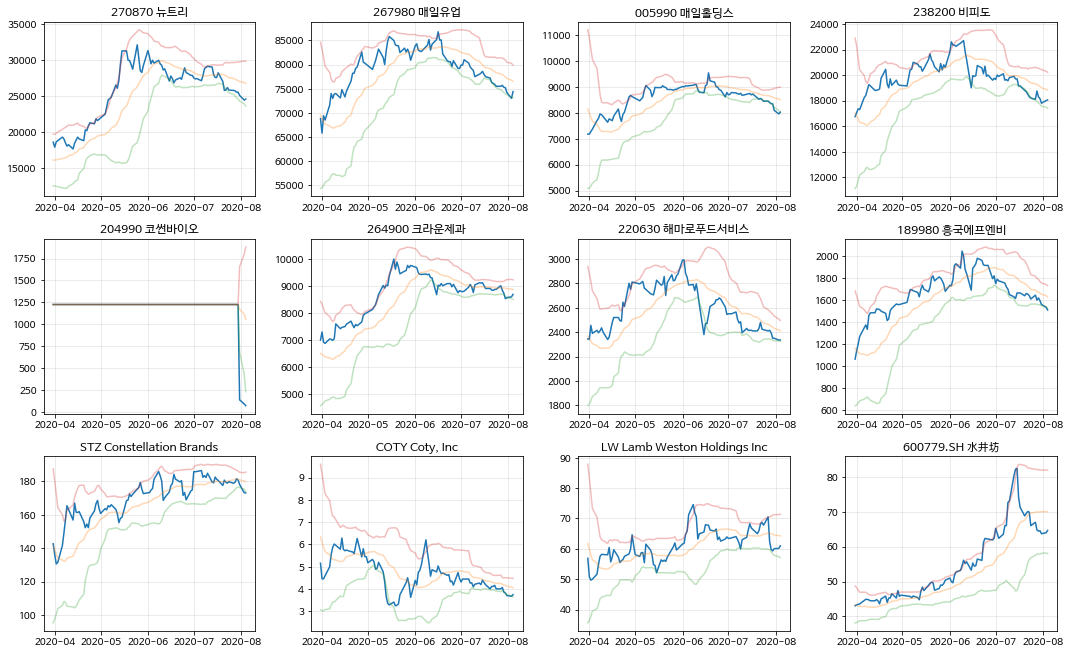

In [74]:
fig = plt.figure(figsize=(15,15),facecolor='white')

for i in df_sign_today.index: 
    symbol = df_sign_today.loc[i,'Symbol']
    name = df_sign_today.loc[i,'Name']
    q = 'select * from history where Symbol == "{}"'.format(symbol)
    price = pd.read_sql(q, conn, parse_dates='Date').sort_values('Date',ascending=True)

    d_lists = pd.date_range(start="2020-03-31",end="2020-08-04",freq='Q-DEC')
    start_date = d_lists[0].strftime('%Y-%m-%d')
    end_date = price.iloc[-1,0]
    price2 = calc_indicator.bband(price)
    idx = (price2['Date'] >= start_date) & (price2['Date'] <= end_date)
    plot_data = price2[idx].drop(columns=['BBand_buySign']).set_index('Date').copy() 

    ax = fig.add_subplot(5,4,i+1)
    x = plot_data.index 
    for col in plot_data.columns:
        y = plot_data[col]
        a = 0.3 if col != 'Close' else 1 
        ax.plot(x,y,label=col,alpha = a)
    ax.set_title(symbol+' '+name)
    # ax.legend()
    ax.grid('both',alpha=0.3)
    ax.set_axisbelow(True)
    ax.xaxis.set_major_locator(mdates.MonthLocator())
plt.tight_layout()
plt.show()

# Appendix 종목 리스트 및 보조지표 계산 함수 

In [77]:
print('한국 종목')
conn = sqlite3.connect('./database.db')
q = 'select * from stock_lists where CO == "KR";'
df2=pd.read_sql(q,conn).reset_index(drop=True)
df2

한국 종목 


,Symbol,Name,Sector,CO
0,011150,CJ씨푸드,기타 식품 제조업,KR
1,097950,CJ제일제당,기타 식품 제조업,KR
2,051500,CJ프레시웨이,음·식료품 및 담배 도매업,KR
3,023150,MH에탄올,알코올음료 제조업,KR
4,065150,MP그룹,음·식료품 및 담배 도매업,KR
5,005610,SPC삼립,기타 식품 제조업,KR
6,043650,국순당,알코올음료 제조업,KR
7,003920,남양유업,낙농제품 및 식용빙과류 제조업,KR
8,311390,네오크레마,기타 식품 제조업,KR
9,086220,네추럴FNP,기타 식품 제조업,KR


In [78]:
print('미국 종목')
conn = sqlite3.connect('./database.db')
q = 'select * from stock_lists where CO == "US";'
df2=pd.read_sql(q,conn).reset_index(drop=True)
df2

미국 종목


,Symbol,Name,Sector,CO
0,MO,Altria Group Inc,Consumer Staples,US
1,ADM,Archer-Daniels-Midland Co,Consumer Staples,US
2,BFB,Brown-Forman Corp.,Consumer Staples,US
3,CPB,Campbell Soup,Consumer Staples,US
4,CHD,Church & Dwight,Consumer Staples,US
5,CLX,The Clorox Company,Consumer Staples,US
6,KO,Coca-Cola Company,Consumer Staples,US
7,CL,Colgate-Palmolive,Consumer Staples,US
8,CAG,Conagra Brands,Consumer Staples,US
9,STZ,Constellation Brands,Consumer Staples,US


In [79]:
print('중국 종목')
conn = sqlite3.connect('./database.db')
q = 'select * from stock_lists where CO == "CN";'
df2=pd.read_sql(q,conn).reset_index(drop=True)
df2

중국 종목


,Symbol,Name,Sector,CO
0,000568.SZ,泸州老窖,白酒,CN
1,000596.SZ,古井贡酒,白酒,CN
2,000729.SZ,燕京啤酒,啤酒,CN
3,000799.SZ,酒鬼酒,白酒,CN
4,000848.SZ,承德露露,软饮料,CN
5,000858.SZ,五粮液,白酒,CN
6,000860.SZ,顺鑫农业,白酒,CN
7,000895.SZ,双汇发展,食品,CN
8,002216.SZ,三全食品,食品,CN
9,002304.SZ,洋河股份,白酒,CN


In [10]:
class calc_indicator():
    # 볼린저밴드를 계산하는 함수
    # 20일 이동평균선의 표준편차 2배수를 가감한 것을 기준으로 함
    # 주가가 밴드 구간의 하위 30%에 머물러 있을 때 매수 고려 구간이라 판단
    def bband(price):
        price = price[['Date', 'Close']].copy()
        d = 20
        bb_signal = price['Close'].rolling(window=d).mean()
        std = price['Close'].rolling(window=d).std()
        price['bb_signal'] = bb_signal
        price['bb_under'] = bb_signal - std * 2
        price['bb_upper'] = bb_signal + std * 2
        price = price.dropna().copy()
        rng = price['bb_upper']-price['bb_under']
        sig = price['bb_under']+rng*0.3
        buy_sig = sig > price['Close']
        price['BBand_buySign'] = buy_sig
        return price
    # MACD를 계산하는 함수
    # 12일 MA와 26일 MA를 활용해 MACD를 구하고
    # MACD 시그널은 MACD의 9일 이동평균을 사용함
    # MACD가 0보다 작고, MACD signal보다 큰 경우를 매수 고려 구간이라 판단
    def macd(price):
        price = price[['Date', 'Close']].copy()
        for i in [12, 26]:
            price['ma{}'.format(i)] = price['Close'].rolling(window=i).mean()
        price.dropna(inplace=True)
        price['macd'] = price['ma12'] - price['ma26']
        price['macd_sig'] = price['macd'].rolling(window=9).mean()
        buy_sig = price['macd'] < 0 & (price['macd'] > price['macd_sig'])
        price['MACD_buySign'] = buy_sig
        return price

    # RSI 지표를 계산하는 함수
    # 14일 평균치를 기준으로 계산하며
    # RSI가 40미만일 때 매수 고려 구간이라 판단
    def rsi(price):
        price = price[['Date', 'Close']].copy()
        close = price['Close'].astype(float)
        U = np.where(close.diff(1) > 0, close.diff(1), 0)
        D = np.where(close.diff(1) < 0, close.diff(1) * (-1), 0)
        AU = pd.Series(U).rolling(window=14).mean()
        AD = pd.Series(D).rolling(window=14).mean()
        RSI = AU / (AD + AU) * 100
        price['RSI'] = RSI
        price.dropna(inplace=True)
        buy_sig = price['RSI'] < 40
        price['RSI_buySign'] = buy_sig
        return price